# Signal Preprocessing

[Classification of ECG Using Ensemble of Residual CNNs with Attention Mechanism](https://ieeexplore.ieee.org/document/9662723)

1. Provided data are expanded into fixed 12-lead configuration. If any lead is missing, the particular matrix row is filled with zeroes. This transformation always outputs a matrix with dimensions (12, time).
2. Resampling: Data are resampled to the sampling frequency of 500 Hz. Polyphase filtering is used when the original sampling frequency is 1000 Hz; otherwise, the FFT method is used for resampling.
3. Filtering: Data are filtered using a zero-phase method with 3rd order Butterworth bandpass filter with frequency band from 1 Hz to 47 Hz.
4. Normalization: Each ECG channel is normalized using a z-score.
5. Zeropadding: Data are zero-padded into the shape of 8192 samples in the time domain. If a signal length is larger than 8192, then the signal is randomly sampled and cut into the length of 8192.
6. Augmentation: During the training phase, randomly choose the lead configuration (e.g. 12, 6, 4, 3, 2). Leads that are not used are filled with zeros.

In [1]:
import os
import wfdb
import numpy as np
from scipy import signal
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [2]:
os.chdir('..')

In [3]:
sig = wfdb.rdrecord('cinc-2021_data/training/cpsc_2018/g4/A3034')
sig_pulse_raw = sig.p_signal[:,0][:600]

print(f"frequency: {sig.fs} Hz")

frequency: 500 Hz


## Butterworth bandpass filter

- Order: 3
- Bandpass Range: 1 Hz ... 47 Hz
- Sample Rate: 500 Hz

In [6]:
b, a = signal.butter(3, [1 / 250, 47 / 250], 'bandpass')
sig_pulse_butter = signal.filtfilt(b, a, sig_pulse_raw)

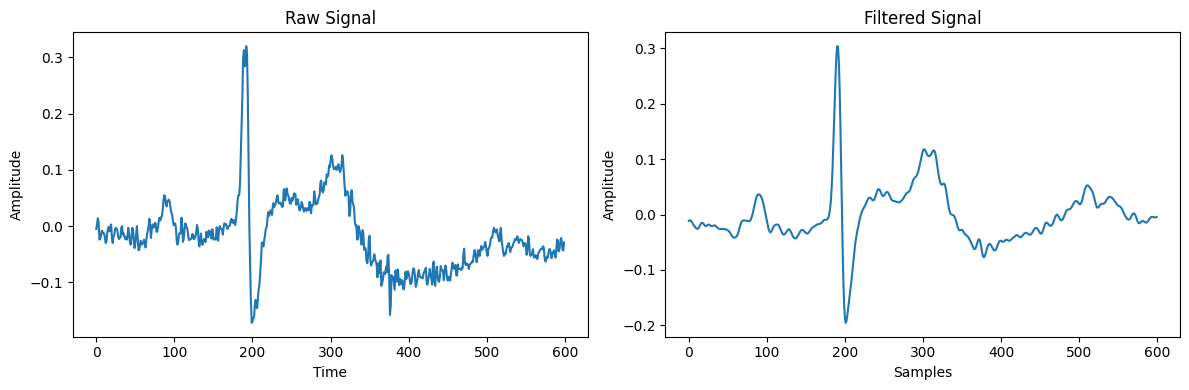

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the raw signal
axs[0].plot(sig_pulse_raw)
axs[0].set_title('Raw Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plot the filtered signal
axs[1].plot(sig_pulse_butter)
axs[1].set_title('Filtered Signal')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Amplitude')

# Show the plot
plt.tight_layout()
plt.show()


In [9]:
sig_pulse_zscore = zscore(sig_pulse_butter, axis=-1)

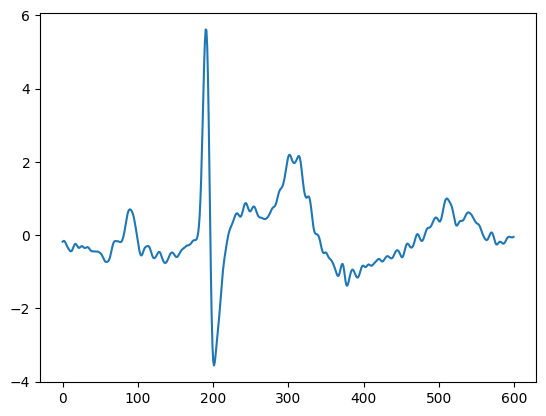

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the raw signal
axs[0].plot(sig_pulse_raw)
axs[0].set_title('Raw Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plot the filtered signal
axs[1].plot(sig_pulse_butter)
axs[1].set_title('Filtered Signal')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Amplitude')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
def zero_padding(x):
    y = np.zeros((12, 5000))
    if x.shape[1]<5000:
        y[:,-x.shape[1]:] = x
    else:
        y = x[:,:5000]
    return y

In [35]:
# source: Classification of ECG Using Ensemble of Residual CNNs with Attention Mechanism
def preprocessing(recording, fs):
    b,a = signal.butter(3, [1 / 250, 47 / 250], 'bandpass')

    if fs==1000:
        recording = signal.resample_poly(recording, up=1, down=2, axis=-1) # to 500Hz
        fs = 500
    elif fs==500:
        pass
    else:
        recording = signal.resample(recording, int(recording.shape[1] * 500 / fs), axis=1)

    recording = signal.filtfilt(b, a, recording)
    # recording = zscore(recording, axis=-1)
    recording = np.nan_to_num(recording)
    # recording = zero_padding(recording)
    return recording

In [41]:
def plot_first_signal(record):
    signal = record.p_signal[:2000, :]
    signal = np.transpose(signal)
    fs = record.fs

    filtered_signal = preprocessing(signal, fs=fs)
    sig_name = record.sig_name

    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(signal[0], label='Raw Signal')
    ax.plot(filtered_signal[0], label='Filtered Signal')
    ax.set_title(f'Signal Comparison')
    ax.legend()

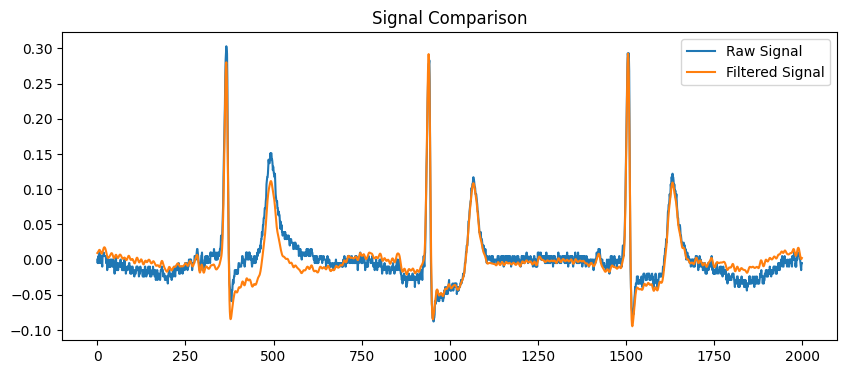

In [42]:
record_257Hz = wfdb.rdrecord('cinc-2021_data/training/ningbo/g1/JS10648')
plot_first_signal(record_257Hz)

# Different Frequency

In [13]:
def plot_signal(record):
    signal = record.p_signal[:9000, :]
    signal = np.transpose(signal)
    fs = record.fs

    filtered_signal = preprocessing(signal, fs=fs)
    sig_name = record.sig_name

    fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(15, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    for i in range(len(signal)):
        ax = axes[i]
        ax.plot(signal[i], label='Raw Signal')
        ax.plot(filtered_signal[i], label='Filtered Signal')
        ax.set_title(f'Lead {sig_name[i]}')
        ax.legend()

# st_petersburg_incart - 257 Hz

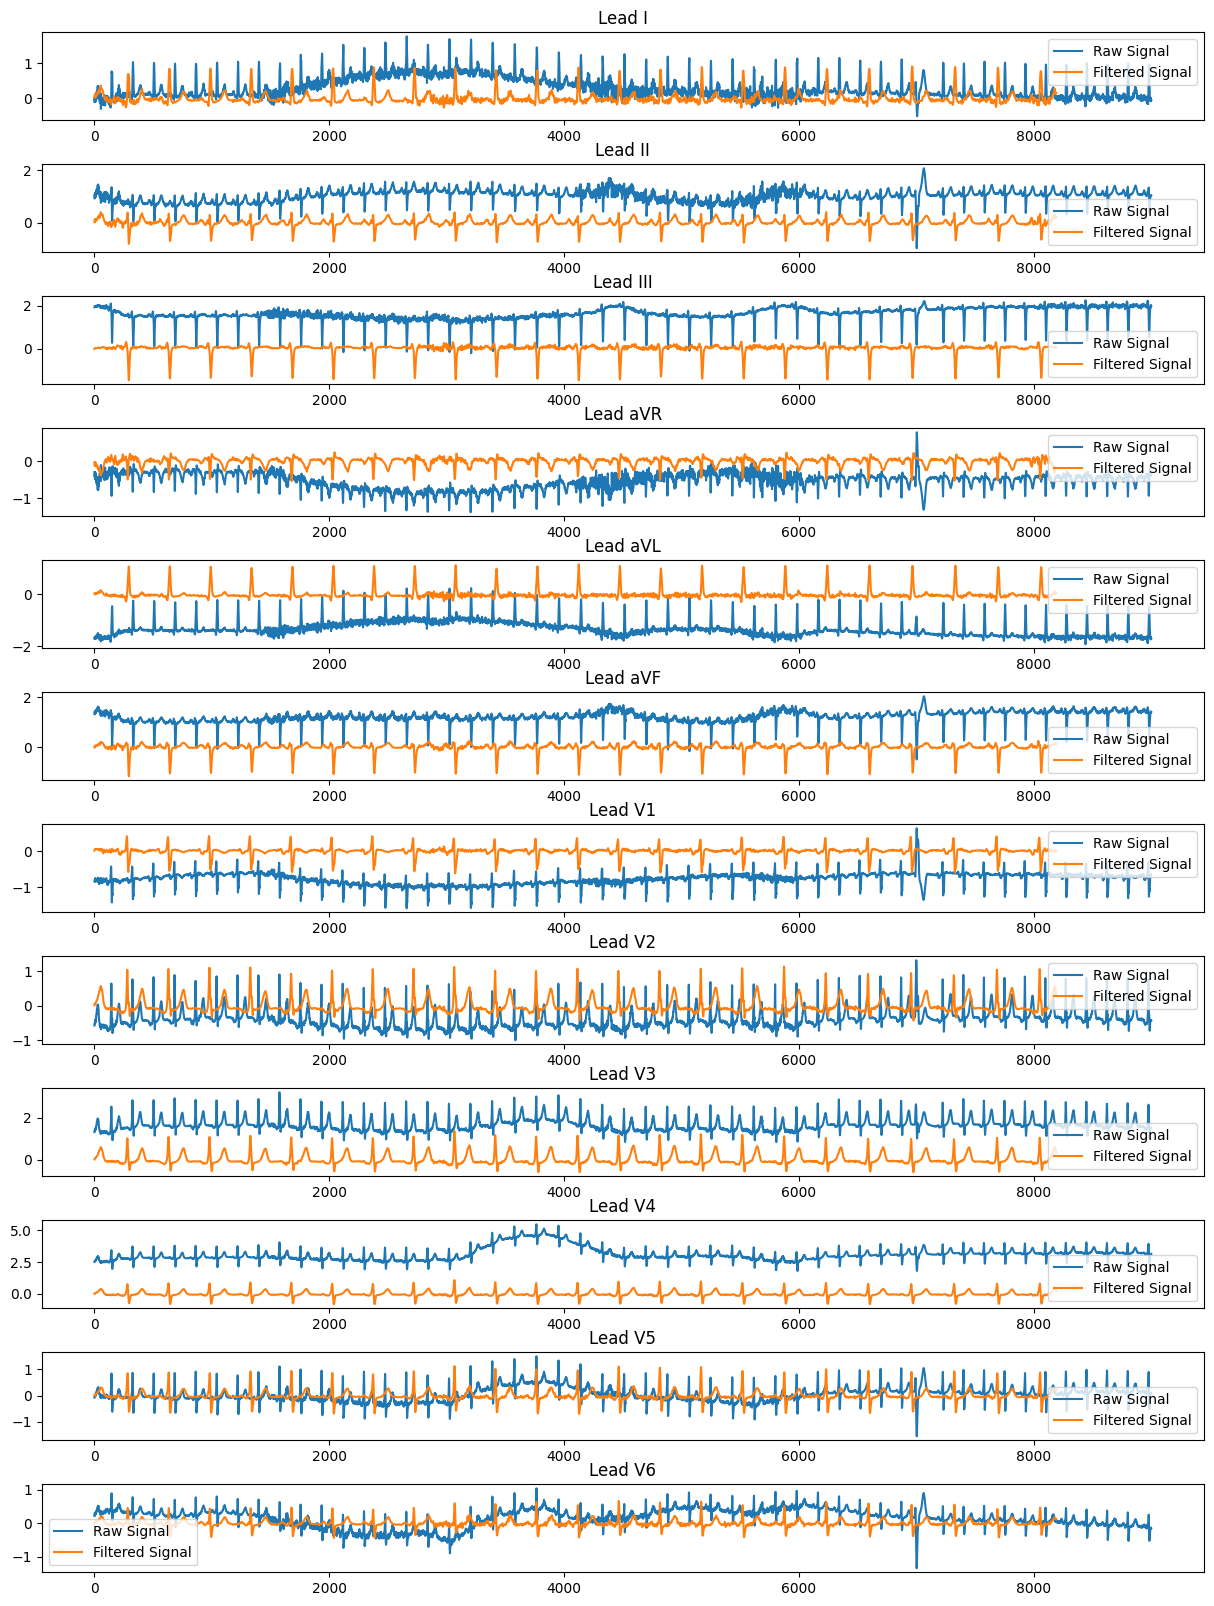

In [14]:
record_257Hz = wfdb.rdrecord('cinc-2021_data/training/st_petersburg_incart/g1/I0068')
plot_signal(record_257Hz)

# cpsc_2018 - 500 Hz

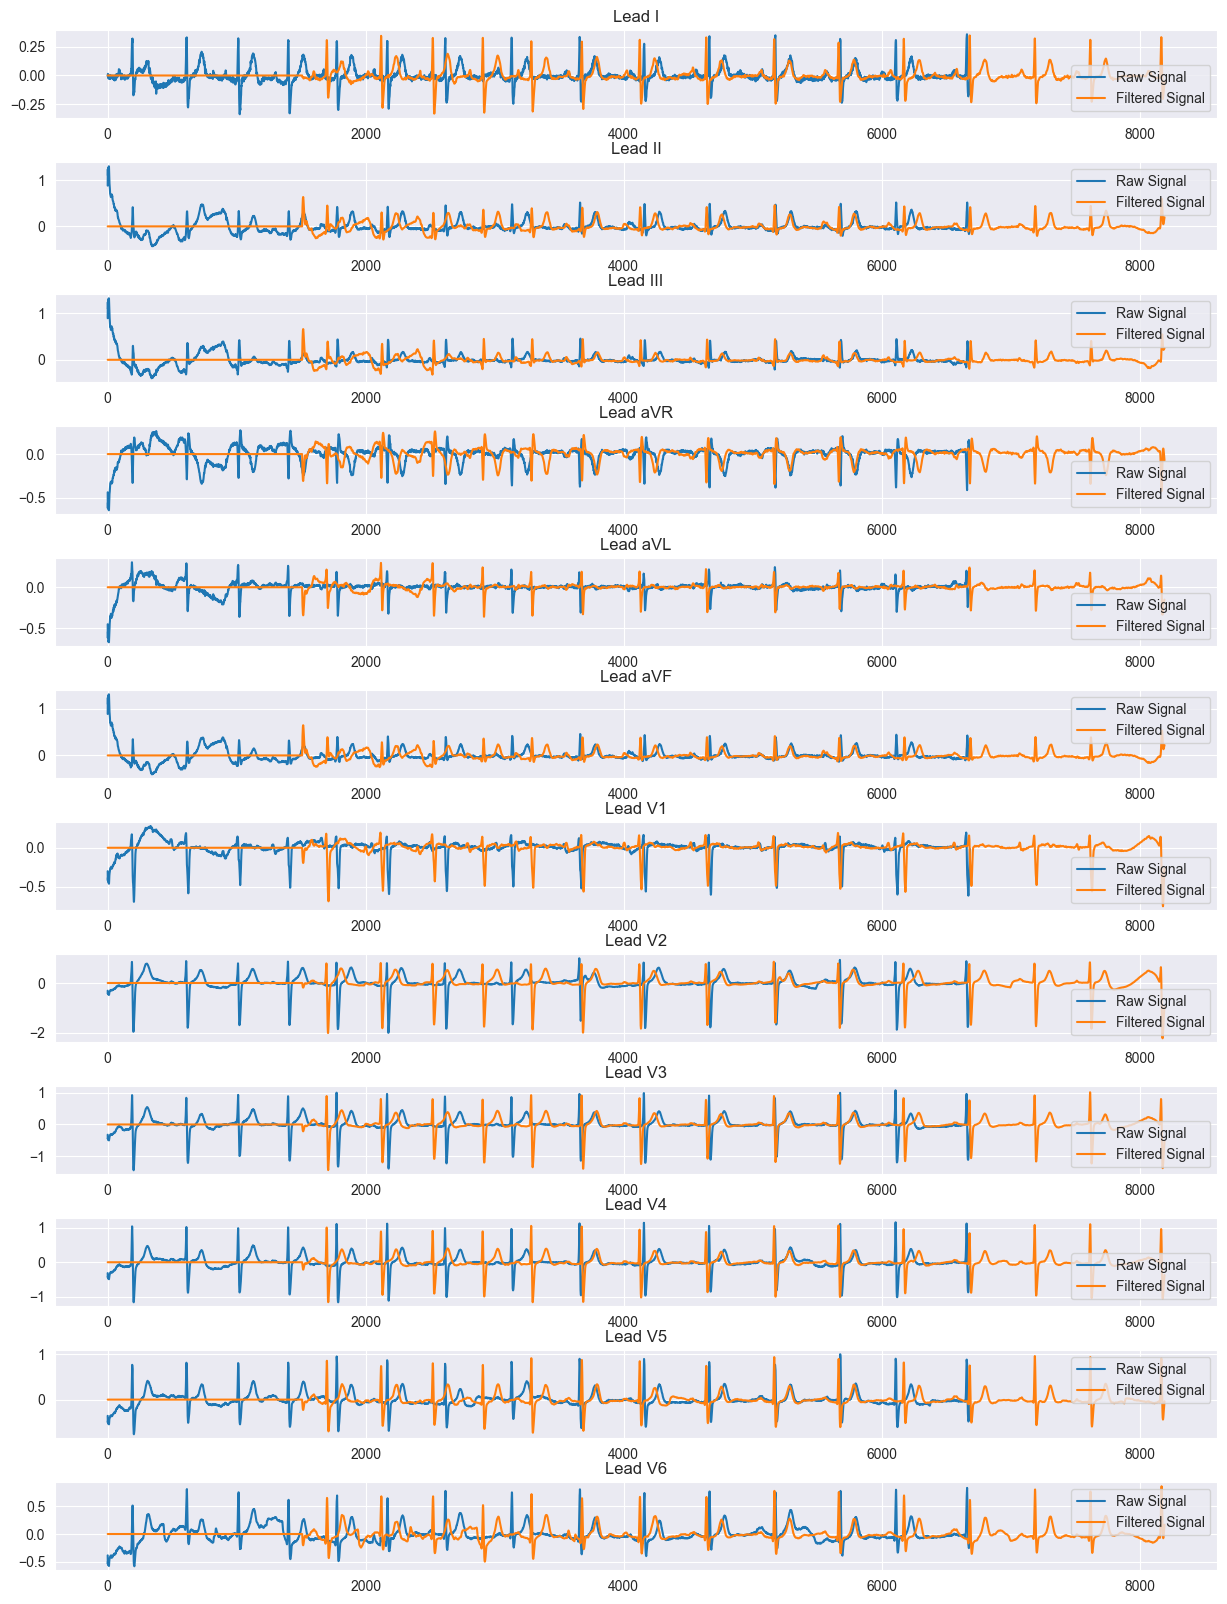

In [44]:
record_500Hz = wfdb.rdrecord('cinc-2021_data/training/cpsc_2018/g4/A3034')
plot_signal(record_500Hz)

# ptb - 1000 Hz

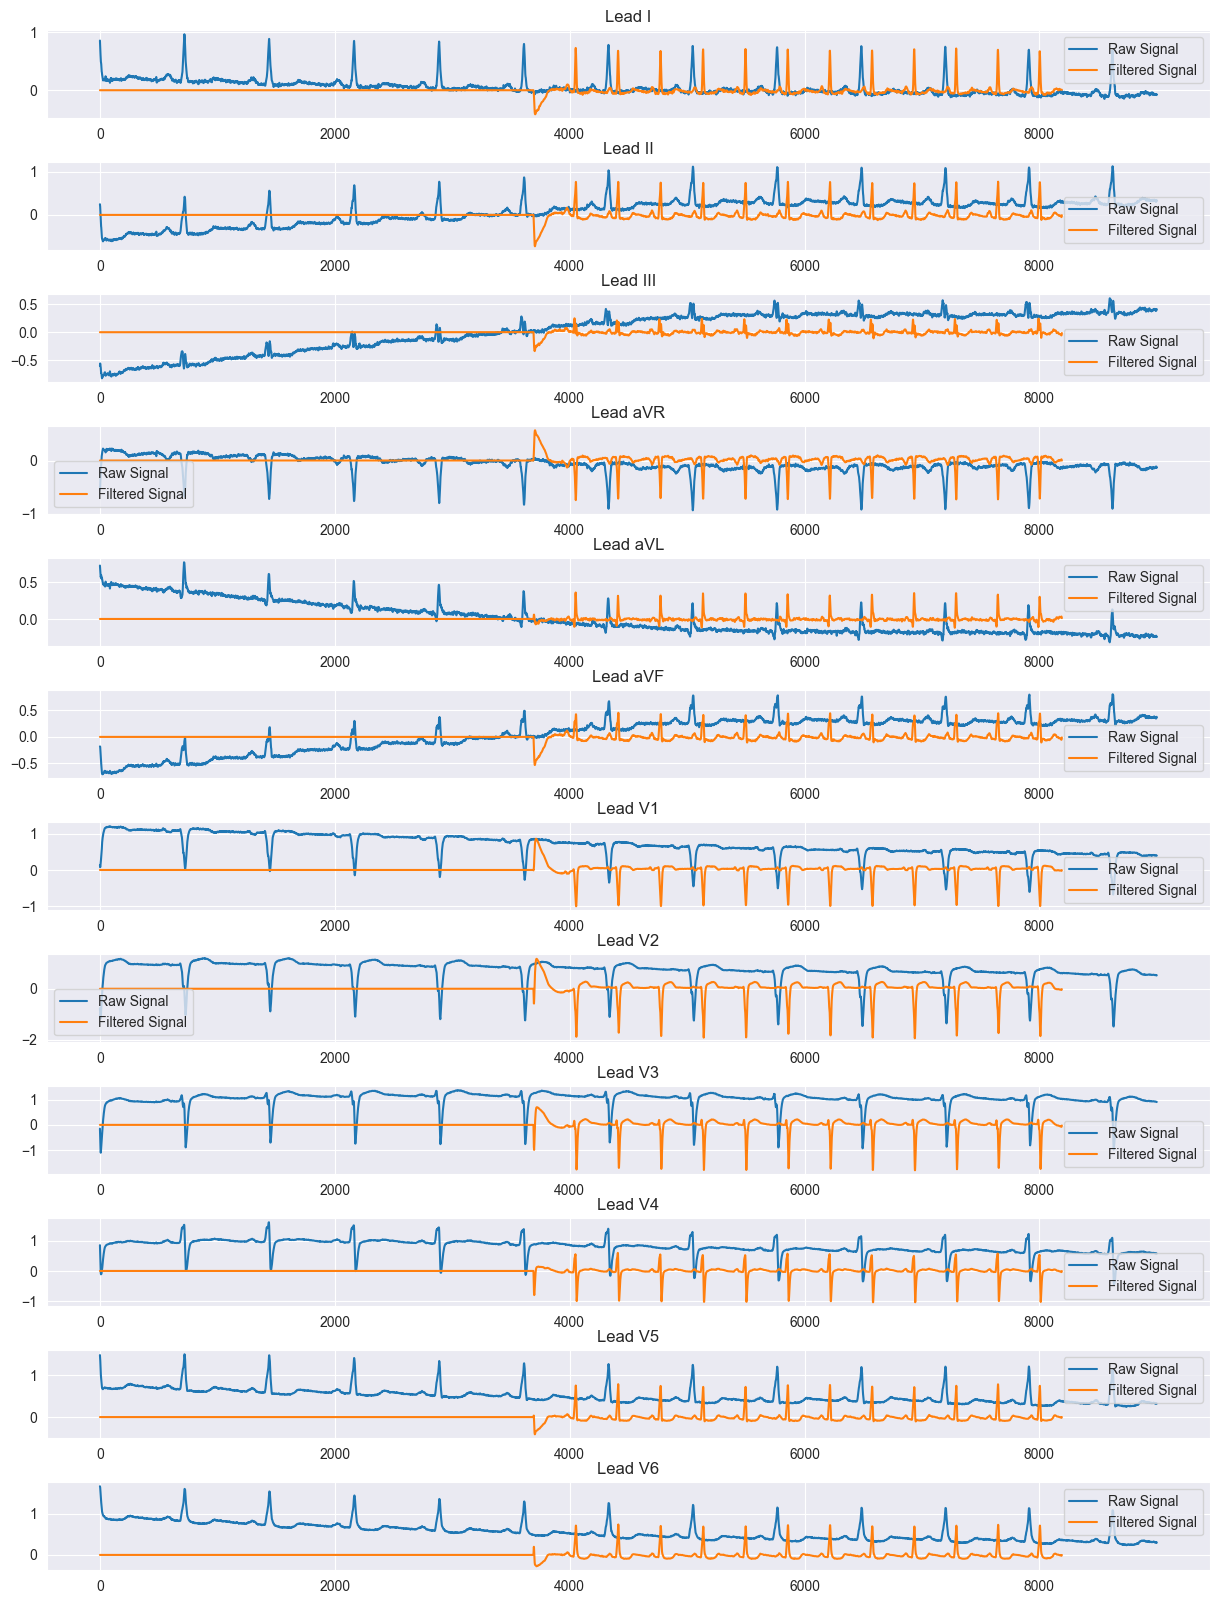

In [45]:
record_1000Hz = wfdb.rdrecord('cinc-2021_data/training/ptb/g1/S0104')
plot_signal(record_1000Hz)